# Predicting Pass Success

This notebook creates an xPass model, where xPass is the probability of a pass being successful given certain features of the circumstances under which a pass is made.

Initially, a simple model is created which simply uses the position on the pitch from which the pass was made, but this is then expanded on to include additional features.

Finally the xPass model is used to produce a scouting report on two players from one league.

### Notes from David Sumpter on the problem

Use p values for seeing whether there is a strong relationship
x and y considered as separate parameters
could do distance from the middle of the pitch, or distance from opponent's goal as an additional parameter
	would be interesting as a single variable model

end-coordinates of a pass - what do you do for unsuccessful passes?

what is a successful pass?
	naively this could just be whether it's successful (ie ,ends up with own player) or unsuccessful (ie, ends up off pitch or with opposition)
	but could be whether you're own player ends up with the ball
	could improve the model by considering this in part ii

What is a good passer?
	Someone who overperforms your passing model - in the same way as xG

Using the same data for test and train - it's not a machine learning course...

When doing the comparison, just compare within the league we care about. Pick out one or two players that are deem to be good players based 
	on the results of our model - a focussed analysis of one or two players you'd be interested in signing (may want to take in context of
	other data on the player, eg basic demographic things like age - eg, you wouldn't want to sign a 33 year old necessarily)

Weakness:
* Fitted over a certain number of leagues
* It would be good to include pressure on player (from tutorial team)
	
Can use ridge-regression in scikit-learn (punishes if too many parameters)

In [1]:
import json
import os
import numpy as np
import pandas as pd

#Plotting
import matplotlib.pyplot as plt
from matplotlib.patches import Arc

#Statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.calibration import calibration_curve

import FCPython

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Loading the data

This assumes that Wyscout data is held in a folder called 'data/' within the repository holding this notebook

In [2]:
def load_wyscout_event_data(data_folder='data/'):
    """
    Given a folder location holding Wyscout data, load all json files for event data and
    put all data in a single dataframe, which is returned.
    """
    
    data_folder = data_folder.strip('/')
    
    event_files = []
    events = []
    
    for root, dirs, files in os.walk(f'{data_folder}/events'):
        for file in files:
            event_files.append(f'{root}/{file}')

    for file_location in event_files:
        with open(file_location, encoding="utf8") as json_data:
            event_df_for_file = pd.DataFrame(json.load(json_data))
            events.append(event_df_for_file)
    
    events_df = pd.concat(events) 
    events_df = events_df.reset_index(drop=True)
    
    return events_df

In [3]:
event_data = load_wyscout_event_data()

# Data exploration

Before doing anything we need to understand what the data we have looks like, let's do a little exploring.

### Questions to answer

* What do passes look like in the data?
* Are there different types of passes?
* How do we know if a pass was successful? 
* Are there different possible definitions of 'success'?
* What are the axes origins for x and y co-ordinates?
* Would it make more sense to shift the origin?
* Other than x and y co-ordinates, what other features could we possibly use in model extensions?
* How can we know the end location of the pass if it is unsuccessful?

In [368]:
class EventDataPipeline:
    def __init__(self):
        self.filters = list()
    
    def add_filters(self, filters_to_add):
        self.filters.extend(filters_to_add)
    
    def run_get_event_data_pipeline(self, event_data):
        event_data = event_data.copy()
        for f in self.filters:
            event_data = f(event_data)
        
        return event_data

    
class PassDataPipeline:
    def __init__(self):
        self.filters = list()
    
    def add_filters(self, filters_to_add):
        self.filters.extend(filters_to_add)
    
    def run_get_pass_data_pipeline(self, event_data):
        pass_data = event_data[event_data['eventName'] == 'Pass'].copy()
        for f in self.filters:
            pass_data = f(pass_data)
        
        return pass_data

In [270]:
def get_shot_assist_flag(event_data):
    """
    Given event data, derive a flag to demonstrate whether an event is an assist for a shot
    """
    event_data = event_data.copy()
    
    next_event_in_same_match = (event_data['matchId'].diff() == 0.0) | (event_data['matchId'].diff().isnull())
    next_event_by_same_team = (event_data['teamId'].diff() == 0.0) | (event_data['teamId'].diff().isnull())
    next_event_a_shot = event_data['eventName'].shift(-1) == 'Shot'
    
    event_data['shot_assist'] = next_event_in_same_match & next_event_by_same_team & next_event_a_shot
    
    return event_data

In [41]:
def remove_rows_with_no_pass_end_position(pass_data):
    """
    All passes should have an end location. If any rows don't, remove them from the data
    """
    pass_data = pass_data.copy()
    number_of_coords = pass_data['positions'].apply(lambda x: len(x))
    pass_data = pass_data[number_of_coords == 2]
    pass_data = pass_data.reset_index(drop=True)
    
    return pass_data
    

def get_success_flag_from_tags(pass_data):
    """
    Extract a success flag from tags field of pass data:
        1801 means success
        1802 mean not a success
    """
    all_tags = pass_data['tags'].copy().apply(lambda x: [tag['id'] for tag in x])
    pass_data['success'] = all_tags.apply(lambda x: True if 1801 in x and 1802 not in x else False)
    
    return pass_data


def get_start_coordinates_of_pass_from_position(pass_data):
    """
    Extract the start co-ordinates of a pass from the position field of the event data
    """
    pass_data = pass_data.copy()
    pass_data['pass_start_x'] = pass_data['positions'].apply(lambda coords: coords[0]['x'])
    pass_data['pass_start_y'] = pass_data['positions'].apply(lambda coords: coords[0]['y'])

    return pass_data


def get_end_coordinates_of_pass_from_position(pass_data):
    """
    Exctract the end co-ordinates of a pass from the position field of the event data
    If there is no end co-ordinates, then assume pass end is same as pass start

    Note, this doesn't make any attempt to work out the intended end 
    co-ordinates of a failed pass
    """
    pass_data = pass_data.copy()

    # For some reason there are two passes for which there are only one co-ordinate
    number_of_coords = pass_data['positions'].apply(lambda x: len(x))
    inferred_end_coordiates = pass_data[number_of_coords == 1]['positions'].apply(
        lambda coords: [{'y': coords[0]['y'], 'x': coords[0]['x']},
                        {'y': coords[0]['y'], 'x': coords[0]['x']}])
    pass_data['positions'].update(inferred_end_coordiates)

    pass_data['pass_end_x'] = pass_data['positions'].apply(
            lambda coords: coords[1]['x'])
    pass_data['pass_end_y'] = pass_data['positions'].apply(
            lambda coords: coords[1]['y'])

    return pass_data


def get_start_coordinates_squared(pass_data):
    """
    Derive new features of start coordinates squared from start coordinates.
    Note that this filter must be applied after get_start_coordinates_of_pass_from_position()
    """
    pass_data = pass_data.copy()
    
    pass_data['pass_start_x_squared'] = pass_data['pass_start_x'] ** 2
    pass_data['pass_start_y_squared'] = pass_data['pass_start_y'] ** 2
    
    return pass_data


def get_start_coordinates_in_metres(pass_data):
    """
    Derive the start co-ordinates in metres from the start co-ordinates.
    Note that this filter must be applied after get_start_coordinates_of_pass_from_position()
    """
    pass_data = pass_data.copy()
    pass_data['pass_start_x_metres'] = pass_data['pass_start_x'] * 105 / 100
    pass_data['pass_start_y_metres'] = pass_data['pass_start_y'] * 65 / 100
    
    return pass_data


def get_product_of_start_coords(pass_data):
    """
    Derive new feature: product of x and y start co-ordinates for pass
    """
    pass_data = pass_data.copy()
    pass_data['start_coords_product'] = pass_data['pass_start_x'] * pass_data['pass_start_y']
    
    return pass_data


def get_pass_type(pass_data):
    """
    Derive boolean fields for each pass type
    """
    pass_data = pass_data.copy()
    for pass_type in ['Simple pass', 'High pass', 'Head pass', 'Smart pass', 'Launch', 'Cross', 'Hand pass']:
        pass_data[pass_type.lower().replace(' ', '_')] = pass_data['subEventName'] == pass_type
    
    return pass_data


def get_angle_and_distance_of_pass(pass_data):
    """
    Derive the angle at which the pass was made and the distance of it
    """
    
    pass_data = pass_data.copy()
    
    x_start_in_metres = pass_data['pass_start_x'] * 105 / 100
    y_start_in_metres = pass_data['pass_start_y'] * 65 / 100
    x_end_in_metres = pass_data['pass_end_x'] * 105 / 100
    y_end_in_metres = pass_data['pass_end_y'] * 65 / 100
    
    dx = x_end_in_metres - x_start_in_metres
    dy = y_end_in_metres - y_start_in_metres
    pass_directly_forwards = dx == 0
    pass_backwards = dx < 0
    
    # If pass directly forwards, angle is 0
    angle_of_pass = pd.Series([0] * len(pass_data))
    angle_of_pass[~pass_directly_forwards] = np.arctan(abs(dy[~pass_directly_forwards] / dx[~pass_directly_forwards]))
    angle_of_pass[pass_backwards] = np.pi - angle_of_pass
    
    pass_data = pass_data.assign(angle_of_pass=angle_of_pass)
    
    pass_data['distance_of_pass'] = np.sqrt(dx**2 + dy**2)
    
    return pass_data


def get_part_of_field_for_pass_start_and_end(pass_data):
    """
    Derive new features for start third of field, end third of field and a score for
    progression up the pitch - which is simply end third - start third
    """
    pass_data = pass_data.copy()
    for start_or_end in ['start', 'end']:
        
        in_first_third = pass_data[f'pass_{start_or_end}_x'] <= 33.3
        in_middle_third = (pass_data[f'pass_{start_or_end}_x'] > 33.3) & (pass_data[f'pass_{start_or_end}_x'] <= 66.6)
        in_final_third = pass_data[f'pass_{start_or_end}_x'] > 66.6

        pass_data[f'{start_or_end}_third_of_field'] = 0
        pass_data.loc[in_first_third, f'{start_or_end}_third_of_field'] = 1
        pass_data.loc[in_middle_third, f'{start_or_end}_third_of_field'] = 2
        pass_data.loc[in_final_third, f'{start_or_end}_third_of_field'] = 3

    pass_data['pitch_progression_score'] = pass_data['end_third_of_field'] - pass_data['start_third_of_field']
    
    return pass_data


def get_end_position_to_goal_details(pass_data):
    """
    Get the distance of the end position from goal and the angle made by lines drawn
    from the end position to the goalposts.
    
    Note these features are inspired by work in SoccermaticsForPython:
        https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython
    """
    
    pass_data = pass_data.copy()
    end_x_from_goal = (100 - pass_data['pass_end_x']) * 105 / 100
    end_y_from_goal_centre = abs(50 - pass_data['pass_end_y']) * 65 / 100

    pass_data['end_distance_from_goal'] = np.sqrt(end_x_from_goal ** 2 + end_y_from_goal_centre ** 2)
    angle = np.arctan(7.32 * end_x_from_goal / (end_x_from_goal ** 2 + end_y_from_goal_centre ** 2 - (7.32 / 2) ** 2))
    angle_less_than_0 = angle < 0
    angle[angle_less_than_0] = np.pi + angle
    pass_data['end_angle_between_goalpost'] = angle

    return pass_data

In [369]:
# This code would load the pass data in one go. As this has all been a bit exploratory, we've built this up bit by bit instead
event_data_pipeline = EventDataPipeline()
event_data_pipeline.add_filters([get_shot_assist_flag])
event_data = event_data_pipeline.run_get_event_data_pipeline(event_data)

pass_data_pipeline = PassDataPipeline()
pass_data_pipeline.add_filters([remove_rows_with_no_pass_end_position, get_success_flag_from_tags, 
                                get_start_coordinates_of_pass_from_position, get_end_coordinates_of_pass_from_position,
                                get_start_coordinates_squared, get_product_of_start_coords, get_pass_type,
                                get_angle_and_distance_of_pass, get_part_of_field_for_pass_start_and_end,
                                get_end_position_to_goal_details])
pass_data = pass_data_pipeline.run_get_pass_data_pipeline(event_data)

In [8]:
event_data.head()

,eventId,eventName,eventSec,id,matchId,matchPeriod,playerId,positions,subEventId,subEventName,tags,teamId
0,8,Pass,2.758649,177959171,2499719,1H,25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",85,Simple pass,[{'id': 1801}],1609
1,8,Pass,4.946850,177959172,2499719,1H,370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",83,High pass,[{'id': 1801}],1609
2,8,Pass,6.542188,177959173,2499719,1H,3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",82,Head pass,[{'id': 1801}],1609
3,8,Pass,8.143395,177959174,2499719,1H,120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",82,Head pass,[{'id': 1801}],1609
4,8,Pass,10.302366,177959175,2499719,1H,167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",85,Simple pass,[{'id': 1801}],1609


In [9]:
event_data.shape

(3251294, 12)

In [10]:
event_data['eventName'].unique()

array(['Pass', 'Duel', 'Foul', 'Free Kick', 'Shot', 'Save attempt',
       'Others on the ball', 'Interruption', 'Goalkeeper leaving line',
       'Offside'], dtype=object)

In [11]:
# pass_data = event_data[event_data['eventName'] == 'Pass'].copy()

In [12]:
pass_data['subEventName'].unique()

array(['Simple pass', 'High pass', 'Head pass', 'Smart pass', 'Launch',
       'Cross', 'Hand pass'], dtype=object)

In [13]:
# What tags to we have, and what do those tags mean?
all_tags = pass_data['tags'].apply(lambda x: [tag['id'] for tag in x])
unique_tags = list(set([item for sublist in all_tags.values for item in sublist]))

In [14]:
unique_tags.sort()
unique_tags

[102,
 201,
 301,
 302,
 401,
 402,
 403,
 502,
 504,
 801,
 901,
 1001,
 1401,
 1801,
 1802,
 1901,
 2001,
 2101]

#### What types of pass do we have in the data

Passes are flagged in the `eventName` field with value `Pass`.
There are seven types of pass: `'Simple pass', 'High pass', 'Head pass', 'Smart pass', 'Launch', 'Cross', 'Hand pass'`
Definitions for these types of passes can be found here https://footballdata.wyscout.com/events-manual/

Do we want to include all of these in our model? Is it fair for example to include `Hand pass` which is presumably made exclusively by goalkeepers?

Alternatively, could we include these as features in our model? This could allow us to identify players who have certain passing skills.

#### What do the tags we get for passing mean?

* 102: Own goal
* 201: Opportunity
* 301: Assist
* 302: Key pass
* 401: Left foot
* 402: Right foot
* 403: Head
* 502: Free space left
* 504: Take on right
* 801: High
* 901: Through
* 1001: Fairplay - this is when a player kicks the ball out so some other player needs medical treatment. Should remove these.
* 1401: Interception
* 1801: Accurate
* 1802: Not accurate
* 1901: Counter attack
* 2001: Dangerous ball lost
* 2101: Blocked

In [15]:
# pass_data['all_tags'] = pass_data['tags'].apply(lambda x: [tag['id'] for tag in x])
# pass_data['success'] = pass_data['all_tags'].apply(lambda x: True if 1801 in x and 1802 not in x else False)

In [16]:
len(pass_data[pass_data['success']]) / len(pass_data)

0.8294698427985249

#### How can we identify a successful pass?

We can see that a pass is successful in the most basic way by looking at the tags: `1801` means successful and `1802` means not successful.

This identifies 83% of passes as being successful across all competitions, which seems about right but maybe a little high.

An alterntive definition of 'successful' could include passes where after any interceptions or duels the passing team retain the ball. This is something to consider in future iterations of the model.

In [17]:
# For some reason there are two passes for which there are only one co-ordinate
number_of_coords = pass_data['positions'].apply(lambda x: len(x))
pass_data[number_of_coords == 1]

,eventId,eventName,eventSec,id,matchId,matchPeriod,playerId,positions,subEventId,subEventName,tags,teamId,success,pass_start_x,pass_start_y,pass_end_x,pass_end_y,pass_start_x_squared,pass_start_y_squared,start_coords_product


In [18]:
# Lets remove these two data points from the passing data
# pass_data = pass_data[number_of_coords == 2]

In [19]:
# pass_data['pass_start_x'] = pass_data['positions'].apply(lambda coords: coords[0]['x'])
# pass_data['pass_start_y'] = pass_data['positions'].apply(lambda coords: coords[0]['y'])
# pass_data['pass_end_x'] = pass_data['positions'].apply(lambda coords: coords[1]['x'])
# pass_data['pass_end_y'] = pass_data['positions'].apply(lambda coords: coords[1]['y'])

In [20]:
print(pass_data['pass_start_x'].min(), pass_data['pass_start_x'].max())
print(pass_data['pass_start_y'].min(), pass_data['pass_start_y'].max())

print(pass_data['pass_end_x'].min(), pass_data['pass_end_x'].max())
print(pass_data['pass_end_y'].min(), pass_data['pass_end_y'].max())

0 100
0 101
0 100
0 101


#### What does the co-ordinate system mean?

In the Wyscout documentation (https://apidocs.wyscout.com/matches-wyid-events#6a-available-schemes-and-relative-positions) the postions are described as being the *position in percentage from the left corner of the attacking team*

This means that we should be able to just use the positions without manipulation or caring about which half we're in. To create other features (eg, anlges/ distances) we will need to convert the co-ordinate system to metres

Looking at the data for a switch in posession confirms the definition from the documentation

In [21]:
pass_data.iloc[15:18]

,eventId,eventName,eventSec,id,matchId,matchPeriod,playerId,positions,subEventId,subEventName,tags,teamId,success,pass_start_x,pass_start_y,pass_end_x,pass_end_y,pass_start_x_squared,pass_start_y_squared,start_coords_product
15,8,Pass,32.805618,177959202,2499719,1H,14853,"[{'y': 5, 'x': 23}, {'y': 19, 'x': 63}]",83,High pass,[{'id': 1802}],1631,False,23,5,63,19,529,25,115
16,8,Pass,35.685082,177959184,2499719,1H,370224,"[{'y': 81, 'x': 37}, {'y': 95, 'x': 45}]",82,Head pass,[{'id': 1802}],1609,False,37,81,45,95,1369,6561,2997
17,8,Pass,36.661264,177959204,2499719,1H,14763,"[{'y': 5, 'x': 55}, {'y': 22, 'x': 67}]",82,Head pass,[{'id': 1801}],1631,True,55,5,67,22,3025,25,275


In [604]:
x_start_metres = pass_data['pass_start_x'] * 105 / 100
y_start_metres = pass_data['pass_start_y'] * 65 / 100

# How does position on the pitch contribute?

Let's start by simply plotting a heatmap of pass start co-ordinates for all passes, completed passes and uncompleted passes to see how these differ. We expect to see more passes fail higher up the pitch and from positions where balls are typically played into the box (ie, crosses, through balls, etc).

In [602]:
def plot_event_heatmap(y_events, x_events, title, no_of_bins=10):
    """
    Given series of event positions (one series for y and one for x coordinates) plot a heatmap 
    for those events, with the pitch split into no_of_bins by no_of_bins areas
    """
    histogram_values = np.histogram2d(y_events, x_events, bins=no_of_bins, range=[[0, 65],[0, 105]])
    fig, ax = FCPython.createPitch(105, 65, 'meters', 'black')
    pos=ax.imshow(histogram_values[0], extent=(0, 105, 0, 65), aspect='auto', cmap=plt.cm.Reds)
    fig.colorbar(pos, ax=ax)
    ax.set_title(title)
    plt.tight_layout()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

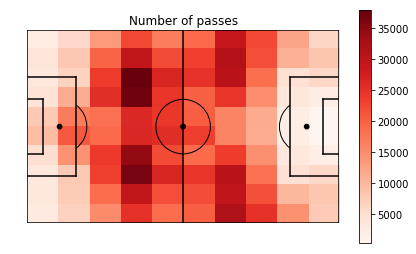

In [605]:
plot_event_heatmap(y_start_metres, x_start_metres, 'Number of passes')

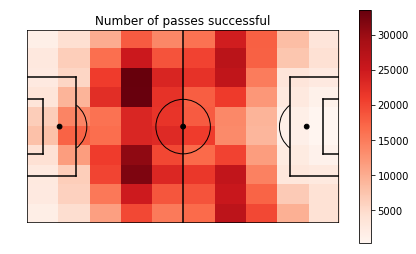

In [606]:
plot_event_heatmap(y_start_metres[pass_data['success']], 
                   x_start_metres[pass_data['success']], 
                   'Number of passes successful')

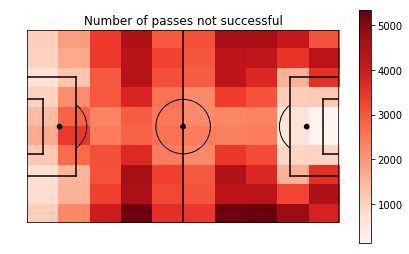

In [607]:
plot_event_heatmap(y_start_metres[~pass_data['success']], 
                   x_start_metres[~pass_data['success']], 
                   'Number of passes not successful')

# Investigating correlation between coordinates and success

Lets plot scatters to see what the relationships look like, then create our first model of pass success.

In [82]:
def plot_relationship_scatter(pass_data, variable_to_plot, curve_parameters=None, title=None):
    """
    Plot the relationship between the variable to plot and the probability of a pass success, based on the data
    provided in the pass_data DataFrame.
    If curve_parameters is also present, then plot the logistic regression curve with these values too
    
    Parameters
    ----------
    pass_data (pd.DataFrame)
        DataFrame containing event data relating to passes, detailing whether each pass is successful, and 
        containing the variable to plot
    
    variable_to_plot (str)
        The name of a field in the pass_data for which to plot a relationship between it and pass success probability
    
    curve_parameters (list)
        Optional. Parameters for a logistic regression to plot.
    
    title (str)
        Optional. If provided, include as a title for the plot
    """
    passcount_dist = np.histogram(pass_data[variable_to_plot], bins=40, range=[0, 100])
    successcount_dist = np.histogram(pass_data[pass_data['success']][variable_to_plot], bins=40, range=[0, 100])
    prob_success = np.divide(successcount_dist[0], passcount_dist[0])
    variable_vals = passcount_dist[1]
    mid_variable_vals = (variable_vals[:-1] + variable_vals[1:]) / 2
    
    fig, ax = plt.subplots(num=2)
    ax.plot(mid_variable_vals, prob_success, linestyle='none', marker= '.', markerSize= 12, color='black')
    
    if curve_parameters is not None:
        exponential_value = np.array([0.0] * len(mid_variable_vals))
        for i, param  in enumerate(curve_parameters):
            exponential_value += param * pow(mid_variable_vals, i)
        xPass_prob = 1 / (1 + np.exp(exponential_value))
        ax.plot(mid_variable_vals, xPass_prob, linestyle='solid', color='black')
    
    ax.set_ylabel('Probability pass success')
    ax.set_xlabel(variable_to_plot)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if title:
        plt.title(title)
        
    plt.show()

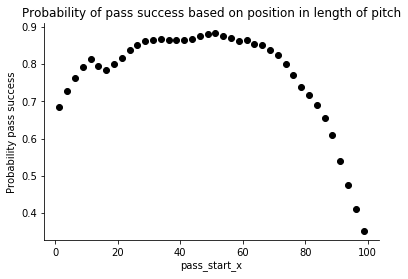

In [85]:
plot_relationship_scatter(pass_data, 'pass_start_x',
                         title='Probability of pass success based on position in length of pitch')

In the x-direction (ie, along the length of the pitch) this confirms what we can see in the plot of the pitch above:
* Near a team's own goal line passes have a middling probability of success. Here passes may be defensive clearances
* In the middle of the park, passes are most likely to be successful. Here teams are more likely to have the ball under less pressure from opponents
* In the final third probability of pass success increases. Passes need to be more creative here to break through an opponent defensive line, and many will be crosses which tend to be less successful.

This looks like a quadratic relationship, so likely that including x<sup>2</sup> will improve the model

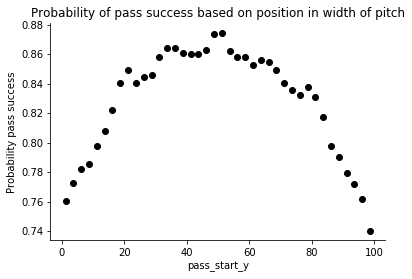

In [83]:
plot_relationship_scatter(pass_data, 'pass_start_y', 
                          title='Probability of pass success based on position in width of pitch')

In the y-direction (ie, along the width of the pitch):
* Passes are less likely to be successful nearer the touch lines. This is not surprising as here we're more likely to see crosses, or other balls into the box
* Passes are more likely to be successful in the centre of the width. Based on the heatmaps above these are likely to be dominated by passes in the centre of the park, where there is often an emphasis on keeping posession.

This looks like a quadratic relationship, so likely that including y<sup>2</sup> will improve the model

# Fitting a logistic regression to variables derived from single variables

Based on what we see in the plots above we should look into logistic regression for x, x<sup>2</sup>, y and y<sup>2</sup>

In [49]:
def calculate_and_plot_logistic_polynomial_regression_curve(pass_data, variables=list(), plot=True):
    """
    Calculate and print logistic regression model for variables provided, and optionally plot curve with real data
    
    Parameters
    ----------
    pass_data (pd.DataFrame)
        DataFrame containing event data relating to passes, detailing whether each pass is successful, and 
        containing the variables for the logistic regression
    
    variables (list)
        Fields in the DataFrame to use in logistic regression model
    
    plot (bool)
        Whether to product a plot. If making a plot it must either be for a single variable model or for a model
        where all variables are powers of a single variable
        
    """
    test_model = smf.glm(formula=f"success ~ {' + '.join(variables)}", data=pass_data, 
                         family=sm.families.Binomial()).fit()
    print(test_model.summary())
    if plot:
        plot_relationship_scatter(pass_data, variables[0], curve_parameters=test_model.params)
    
    return test_model.params

                          Generalized Linear Model Regression Results                          
Dep. Variable:     ['success[False]', 'success[True]']   No. Observations:              1665506
Model:                                             GLM   Df Residuals:                  1665504
Model Family:                                 Binomial   Df Model:                            1
Link Function:                                   logit   Scale:                             1.0
Method:                                           IRLS   Log-Likelihood:            -7.5385e+05
Date:                                 Sun, 13 Sep 2020   Deviance:                   1.5077e+06
Time:                                         18:31:01   Pearson chi2:                 1.68e+06
No. Iterations:                                      5                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

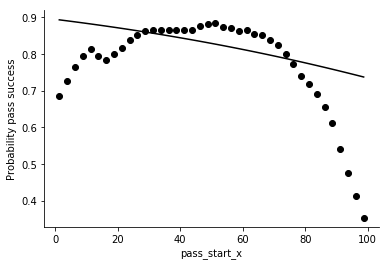

In [31]:
calculate_and_plot_logistic_polynomial_regression_curve(pass_data, ['pass_start_x'])

This doesn't look great, let's have a look at what happens if we include x<sup>2</sup> too

In [32]:
# pass_data['pass_start_x_squared'] = pass_data['pass_start_x']**2
# pass_data['pass_start_y_squared'] = pass_data['pass_start_y']**2

                          Generalized Linear Model Regression Results                          
Dep. Variable:     ['success[False]', 'success[True]']   No. Observations:              1665506
Model:                                             GLM   Df Residuals:                  1665503
Model Family:                                 Binomial   Df Model:                            2
Link Function:                                   logit   Scale:                             1.0
Method:                                           IRLS   Log-Likelihood:            -7.3285e+05
Date:                                 Sun, 13 Sep 2020   Deviance:                   1.4657e+06
Time:                                         18:31:13   Pearson chi2:                 1.67e+06
No. Iterations:                                      5                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------

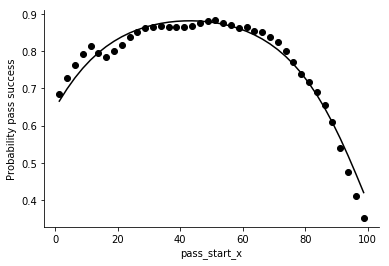

In [33]:
calculate_and_plot_logistic_polynomial_regression_curve(pass_data, ['pass_start_x', 'pass_start_x_squared'])

                          Generalized Linear Model Regression Results                          
Dep. Variable:     ['success[False]', 'success[True]']   No. Observations:              1665506
Model:                                             GLM   Df Residuals:                  1665504
Model Family:                                 Binomial   Df Model:                            1
Link Function:                                   logit   Scale:                             1.0
Method:                                           IRLS   Log-Likelihood:            -7.6056e+05
Date:                                 Sun, 13 Sep 2020   Deviance:                   1.5211e+06
Time:                                         18:31:21   Pearson chi2:                 1.67e+06
No. Iterations:                                      4                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

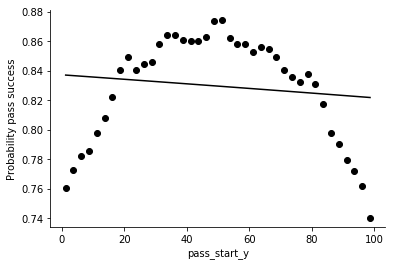

In [34]:
calculate_and_plot_logistic_polynomial_regression_curve(pass_data, ['pass_start_y'])

As was the case for x, this is pretty terrible. But we always thought a quadratic may make more sense. Let's look into that.

                          Generalized Linear Model Regression Results                          
Dep. Variable:     ['success[False]', 'success[True]']   No. Observations:              1665506
Model:                                             GLM   Df Residuals:                  1665503
Model Family:                                 Binomial   Df Model:                            2
Link Function:                                   logit   Scale:                             1.0
Method:                                           IRLS   Log-Likelihood:            -7.5422e+05
Date:                                 Sun, 13 Sep 2020   Deviance:                   1.5084e+06
Time:                                         18:31:37   Pearson chi2:                 1.67e+06
No. Iterations:                                      5                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------

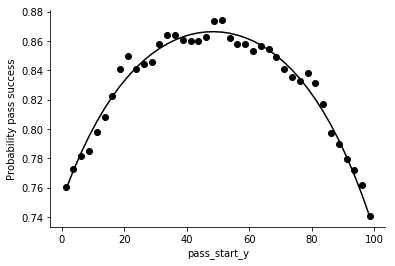

In [35]:
calculate_and_plot_logistic_polynomial_regression_curve(pass_data, ['pass_start_y', 'pass_start_y_squared'])

# Fitting a logistic regression to variables derived from many base variables

We have seen that a logistic regression using pass start co-ordinates and pass start co-ordinates squared fit the probability scatters well when we use just a single variable.
Now let's look at what happens for combinations of these variables:
* x_start + y_start
* x_start + x_start<sup>2</sup> + y_start + x_start<sup>2</sup>
* x_start + x_start<sup>2</sup> + y_start + x_start<sup>2</sup> + x_start * y_start

In [182]:
def fit_logistic_regression_model(pass_data, variables=list()):
    """
    Calculate and print logistic regression model for variables provided, and optionally plot curve with real data
    
    Parameters
    ----------
    pass_data (pd.DataFrame)
        DataFrame containing event data relating to passes, detailing whether each pass is successful, and 
        containing the variables for the logistic regression
    
    variables (list)
        Fields in the DataFrame to use in logistic regression model
    
    plot (bool)
        Whether to product a plot. If making a plot it must either be for a single variable model or for a model
        where all variables are powers of a single variable
        
    """
    test_model = smf.glm(formula=f"success ~ {' + '.join(variables)}", data=pass_data, 
                         family=sm.families.Binomial()).fit()
    print(test_model.summary())
    
    return test_model.params

In [183]:
def calculate_xPass(pass_to_evaluate, model_parameters): 
    """
    Given a row of event data for a pass, b_values for a logistic regression and 
    the model variables, calculate the xPass for the pass.
    """
    bsum = model_parameters[0]
    for i in model_parameters[1:].index:
        variable_name = i.split('[')[0]
        b_val = model_parameters[i]
        bsum = bsum + b_val * pass_to_evaluate[variable_name]
    
    xPass = 1 / (1 + np.exp(bsum))

    return xPass

In [184]:
def plot_calibration_curve(pass_data_with_predictions, save_plot=False):
    """
    Plot calibration curve - given pass data with predictions produce plot to show how
    well calibrated the model that made those predictions is
    """
    
    plt.figure(figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    fraction_of_positives, mean_predicted_value = calibration_curve(pass_data_with_predictions['success'],
                                                                    pass_data_with_predictions['xPass'],
                                                                    n_bins=10)
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="model")
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')
    
    if save_plot:
        plt.savefig('Output/calibration_curve.pdf', dpi=300, bbox_inches="tight")
    plt.show()

In [194]:
def fit_and_evaluate_model(pass_data, model_variables):
    """
    Given a feature vector for pass data, and a list of variables from that vector to 
    use in the model:
        * fit a logistic regression
        * calculate xPass for the rows in the pass data
        * plot a calibration curve to see how well calibrated model is
    
    Return pass data with xPass as an additional field
    """
    
    pass_data = pass_data.copy()
    
    model_params = fit_logistic_regression_model(pass_data, model_variables)
    pass_data['xPass'] = pass_data.apply(lambda x: calculate_xPass(x, model_params), axis=1)
    plot_calibration_curve(pass_data)
    
    return pass_data

                          Generalized Linear Model Regression Results                          
Dep. Variable:     ['success[False]', 'success[True]']   No. Observations:              1665506
Model:                                             GLM   Df Residuals:                  1665503
Model Family:                                 Binomial   Df Model:                            2
Link Function:                                   logit   Scale:                             1.0
Method:                                           IRLS   Log-Likelihood:            -7.5374e+05
Date:                                 Sat, 19 Sep 2020   Deviance:                   1.5075e+06
Time:                                         16:21:23   Pearson chi2:                 1.68e+06
No. Iterations:                                      5                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

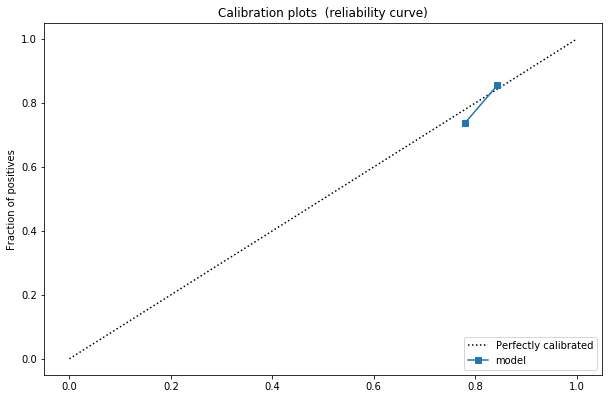

In [195]:
pass_data_for_simplest_model = fit_and_evaluate_model(pass_data,
                                                      ['pass_start_x', 'pass_start_y'])

                          Generalized Linear Model Regression Results                          
Dep. Variable:     ['success[False]', 'success[True]']   No. Observations:              1665506
Model:                                             GLM   Df Residuals:                  1665501
Model Family:                                 Binomial   Df Model:                            4
Link Function:                                   logit   Scale:                             1.0
Method:                                           IRLS   Log-Likelihood:            -7.2937e+05
Date:                                 Sat, 19 Sep 2020   Deviance:                   1.4587e+06
Time:                                         16:28:43   Pearson chi2:                 1.67e+06
No. Iterations:                                      5                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------

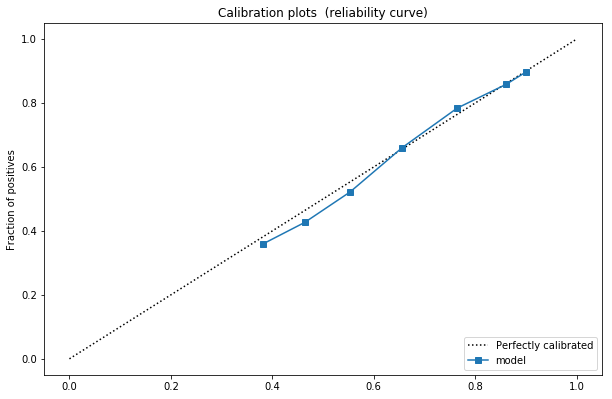

In [196]:
pass_data_for_coordinates_squared = fit_and_evaluate_model(
    pass_data, ['pass_start_x', 'pass_start_y', 'pass_start_x_squared', 'pass_start_y_squared'])

The p-value is 0 for all of these variables so we have a good fit here

                          Generalized Linear Model Regression Results                          
Dep. Variable:     ['success[False]', 'success[True]']   No. Observations:              1665506
Model:                                             GLM   Df Residuals:                  1665500
Model Family:                                 Binomial   Df Model:                            5
Link Function:                                   logit   Scale:                             1.0
Method:                                           IRLS   Log-Likelihood:            -7.2937e+05
Date:                                 Sat, 19 Sep 2020   Deviance:                   1.4587e+06
Time:                                         16:36:41   Pearson chi2:                 1.67e+06
No. Iterations:                                      5                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------

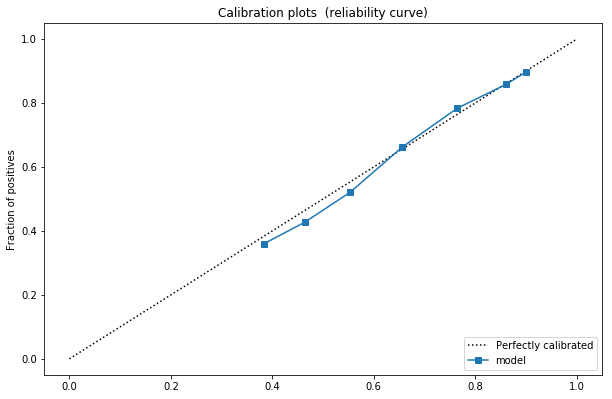

In [197]:
pass_data_for_coord_product = fit_and_evaluate_model(
    pass_data,
    ['pass_start_x', 'pass_start_y', 'pass_start_x_squared', 'pass_start_y_squared', 'start_coords_product'])

The p-value for start_coords_product is 0.001 so looks like this is also predictive

Let's also look at what happens if we include pass type in our model

                          Generalized Linear Model Regression Results                          
Dep. Variable:     ['success[False]', 'success[True]']   No. Observations:              1665506
Model:                                             GLM   Df Residuals:                  1665494
Model Family:                                 Binomial   Df Model:                           11
Link Function:                                   logit   Scale:                             1.0
Method:                                           IRLS   Log-Likelihood:            -6.1527e+05
Date:                                 Sat, 19 Sep 2020   Deviance:                   1.2305e+06
Time:                                         16:45:33   Pearson chi2:                 1.65e+06
No. Iterations:                                      6                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------

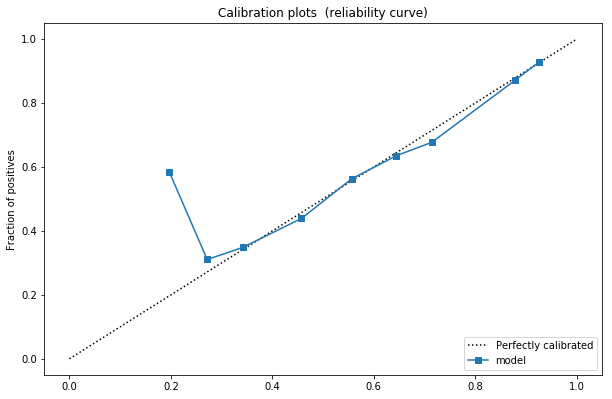

In [198]:
pass_data_for_pass_type = fit_and_evaluate_model(
    pass_data, 
    ['pass_start_x', 'pass_start_y', 'pass_start_x_squared', 'pass_start_y_squared', 
     'start_coords_product', 'simple_pass', 'high_pass', 'head_pass',
     'smart_pass', 'launch', 'cross', 'hand_pass'])

If we also inlcude fields for pass type these also correlate with pass success, with p-value zero

                          Generalized Linear Model Regression Results                          
Dep. Variable:     ['success[False]', 'success[True]']   No. Observations:              1665506
Model:                                             GLM   Df Residuals:                  1665488
Model Family:                                 Binomial   Df Model:                           17
Link Function:                                   logit   Scale:                             1.0
Method:                                           IRLS   Log-Likelihood:            -6.0272e+05
Date:                                 Sat, 19 Sep 2020   Deviance:                   1.2054e+06
Time:                                         21:40:05   Pearson chi2:                 1.65e+06
No. Iterations:                                      6                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

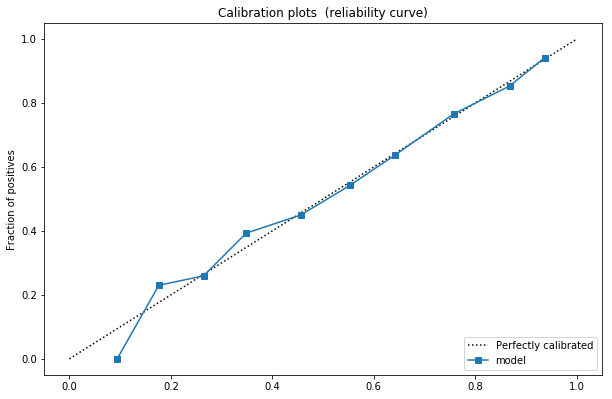

In [383]:
pass_data_with_all_features = fit_and_evaluate_model(
    pass_data, 
    ['pass_start_x', 'pass_start_y', 'pass_start_x_squared', 'pass_start_y_squared', 
     'start_coords_product', 'simple_pass', 'high_pass', 'head_pass',
     'smart_pass', 'launch', 'cross', 'hand_pass', 'start_third_of_field',
     'end_third_of_field', 'pitch_progression_score', 'angle_of_pass',
     'distance_of_pass', 'end_distance_from_goal', 'end_angle_between_goalpost'])

# Plot xPass on field and evaluate players

Using our best xPass model lets look at which players are especially good at playing passes

Then lets also plot xPass for one of our models

                          Generalized Linear Model Regression Results                          
Dep. Variable:     ['success[False]', 'success[True]']   No. Observations:              1665506
Model:                                             GLM   Df Residuals:                  1665500
Model Family:                                 Binomial   Df Model:                            5
Link Function:                                   logit   Scale:                             1.0
Method:                                           IRLS   Log-Likelihood:            -7.2937e+05
Date:                                 Sat, 19 Sep 2020   Deviance:                   1.4587e+06
Time:                                         21:31:50   Pearson chi2:                 1.67e+06
No. Iterations:                                      5                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------

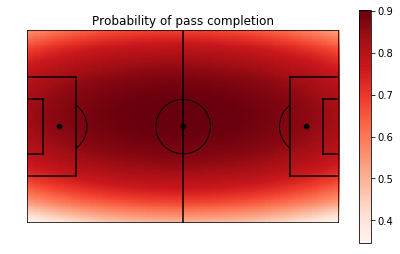

In [372]:
model_parameters_for_x_y_model = fit_logistic_regression_model(
    pass_data,
    ['pass_start_x', 'pass_start_y', 'pass_start_x_squared', 'pass_start_y_squared', 'start_coords_product'])

ppass_2d=np.zeros((100,100))
for x in range(100):
    for y in range(100):
        pass_dict = dict()
        pass_dict['pass_start_x'] = x
        pass_dict['pass_start_y'] = y
        pass_dict['pass_start_x_squared'] = x ** 2
        pass_dict['pass_start_y_squared'] = y ** 2
        pass_dict['start_coords_product'] = x * y

        ppass_2d[x, y] =  calculate_xPass(pass_dict, model_parameters)

fig, ax = FCPython.createPitch(105, 65, 'meters', 'black')
pos = ax.imshow(ppass_2d, extent=(0, 105, 0, 65), aspect='auto', cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Probability of pass completion')
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [377]:
def get_competition_id(competition_name, data_folder='data'):
    """
    Open competitions data json and get competition id for requested competition
    """
    data_folder = data_folder.strip('/')

    with open(f'{data_folder}/competitions.json', encoding="utf8") as json_data:
        competition_data = pd.DataFrame(json.load(json_data))
    
    competition_id = competition_data[competition_data['name'] == competition_name]['wyId'].values[0]
    
    return competition_id


def get_wyscout_match_ids_for_competition(competition_id, data_folder='data'):
    """
    Given a competition id and a folder location holding Wyscout data, load all 
    json files for match data and get match ids for all matches from desired 
    competition
    """
    data_folder = data_folder.strip('/')
    
    match_files = []
    matches = []
    
    for root, dirs, files in os.walk(f'{data_folder}/matches'):
        for file in files:
            match_files.append(f'{root}/{file}')

    for file_location in match_files:
        with open(file_location, encoding="utf8") as json_data:
            match_df_for_file = pd.DataFrame(json.load(json_data))
            matches.append(match_df_for_file)
    
    matches_df = pd.concat(matches) 
    matches_df = matches_df.reset_index(drop=True)
    
    matches_for_competition = matches_df[matches_df['competitionId'] == competition_id]
    match_ids_for_competition = matches_for_competition['wyId'].unique()

    return match_ids_for_competition

In [378]:
def get_pass_data_for_competition(pass_data,
                                  competition_to_evaluate,
                                  data_folder='data/'):
    pass_data = pass_data.copy()

    competition_to_evaluate_id = get_competition_id(competition_to_evaluate,
                                                   data_folder=data_folder)
    competition_match_ids = get_wyscout_match_ids_for_competition(competition_to_evaluate_id,
                                                                 data_folder=data_folder)
    pass_data_for_competition = pass_data[pass_data['matchId'].isin(competition_match_ids)].copy()
    
    return pass_data_for_competition

In [411]:
def get_player_data(data_folder='data/'):
    """
    Get Wyscout player data and return in a dataframe
    """
    data_folder = data_folder.strip('/')
    with open(f'{data_folder}/players.json', encoding="utf8") as json_data:
        player_data = pd.DataFrame(json.load(json_data))
    
    player_data['player_position'] = player_data['role'].apply(lambda x: x['name'])
    
    return player_data

In [550]:
competition_to_evaluate = 'English first division'
data_folder = 'data/'

pass_data_for_competition = get_pass_data_for_competition(pass_data_with_all_features,
                                                          competition_to_evaluate,
                                                          data_folder)
pass_data_for_competition['pass_outcome_vs_xPass'] = pass_data_for_competition['success'] - pass_data_for_competition['xPass']

First naive attempt - just looking at xPass added value

In [551]:
total_x_pass = pass_data_for_competition[['playerId', 'pass_outcome_vs_xPass']].groupby('playerId').sum()
total_x_pass.reset_index(inplace=True)
total_x_pass = total_x_pass.sort_values(by='pass_outcome_vs_xPass', ascending=False)
player_data = get_player_data(data_folder)
player_data_with_total_xPass = total_x_pass.merge(player_data, left_on='playerId', right_on='wyId')

In [571]:
player_data_with_total_xPass.head(5)

,playerId,pass_outcome_vs_xPass,birthArea,birthDate,currentNationalTeamId,currentTeamId,firstName,foot,height,lastName,middleName,passportArea,role,shortName,weight,wyId,player_position,pass_attempt_count,xPass_per_pass
311,26150,15.811852,"{'name': 'France', 'id': 250, 'alpha3code': 'F...",1991-02-21,16009,1625,Riyad,left,179,Mahrez,,"{'name': 'Algeria', 'id': 12, 'alpha3code': 'D...","{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",R. Mahrez,62,26150,Midfielder,334,0.047341
170,8561,15.758881,"{'name': 'England', 'id': 0, 'alpha3code': 'XE...",1987-05-08,null,1633,Mark,right,180,Noble,,"{'name': 'Ireland Republic', 'id': 372, 'alpha...","{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",M. Noble,70,8561,Midfielder,264,0.059693
139,8317,13.774297,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",1986-01-08,1598,1625,David Josu\u00e9,left,173,Jim\u00e9nez Silva,,"{'name': 'Spain', 'id': '724', 'alpha3code': '...","{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",David Silva,67,8317,Midfielder,334,0.041240
158,8464,12.868876,"{'name': 'England', 'id': '0', 'alpha3code': '...",1989-11-21,2413,1625,Fabian,left,174,Delph,,"{'name': 'Guyana', 'id': '328', 'alpha3code': ...","{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",F. Delph,60,8464,Midfielder,151,0.085224
140,8319,12.315081,"{'name': 'England', 'id': 0, 'alpha3code': 'XE...",1986-01-04,null,1612,James,right,176,Milner,,"{'name': 'England', 'id': 0, 'alpha3code': 'XE...","{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",J. Milner,70,8319,Midfielder,278,0.044299


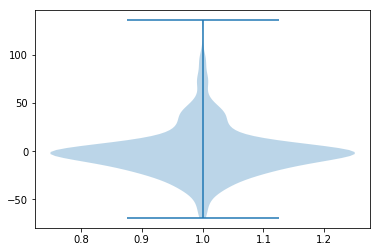

In [553]:
fig, ax = plt.subplots()
ax.violinplot(total_x_pass['pass_outcome_vs_xPass'])
plt.show()

### What to do for a person:

A more sophisticated approach:

* Identify hardest passes, and look for players in a certain position who are best at making these
    * Hardest passes can be passes which model thinks have a less than X% chance of success
    * When looking for players who make these - what proportion of hard passes attempted do they complete?
* What is their xPass difference?
* Where on the pitch are they making difficult passes?
* Plot heatmap for player to compare with overall

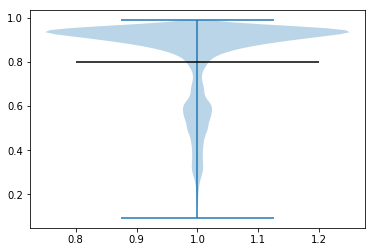

In [554]:
fig, ax = plt.subplots()
ax.violinplot(pass_data_for_competition['xPass'])
ax.hlines(y=0.8, xmin=0.8, xmax=1.2)
plt.show()

Looking at this violon plot for xPass for each pass in the competition data, we can see that the majority of passes are above 0.8 xPass. So let's restrict ourselves to looking at passes which have a 80% chance or lower of being successful accoring to our model

In [555]:
low_probability_passes = pass_data_for_competition[pass_data_for_competition['xPass'] <= 0.8]

In [564]:
# Get count of passes per player, xPass added value per player and average xPass added per pass - just looking at midfielders
total_x_pass = low_probability_passes[['playerId', 'pass_outcome_vs_xPass']].groupby('playerId').sum()
total_x_pass.reset_index(inplace=True)
total_passes = low_probability_passes[['playerId', 'eventId']].groupby('playerId').count()
total_passes.reset_index(inplace=True)
total_passes = total_passes.rename(columns={'eventId': 'pass_attempt_count'})
player_data_with_total_xPass = total_x_pass.merge(player_data, left_on='playerId', right_on='wyId')
player_data_with_total_xPass = player_data_with_total_xPass.merge(total_passes, on='playerId')
player_data_with_total_xPass = player_data_with_total_xPass[player_data_with_total_xPass['player_position'] == 'Midfielder']
player_data_with_total_xPass['xPass_per_pass'] = player_data_with_total_xPass['pass_outcome_vs_xPass'] / player_data_with_total_xPass['pass_attempt_count']

player_data_with_total_xPass = player_data_with_total_xPass[player_data_with_total_xPass['pass_attempt_count'] >= 46]
player_data_with_total_xPass = player_data_with_total_xPass.sort_values(by='pass_outcome_vs_xPass', ascending=False)
player_data_with_total_xPass.head(5)

,playerId,pass_outcome_vs_xPass,birthArea,birthDate,currentNationalTeamId,currentTeamId,firstName,foot,height,lastName,middleName,passportArea,role,shortName,weight,wyId,player_position,pass_attempt_count,xPass_per_pass
311,26150,15.811852,"{'name': 'France', 'id': 250, 'alpha3code': 'F...",1991-02-21,16009,1625,Riyad,left,179,Mahrez,,"{'name': 'Algeria', 'id': 12, 'alpha3code': 'D...","{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",R. Mahrez,62,26150,Midfielder,334,0.047341
170,8561,15.758881,"{'name': 'England', 'id': 0, 'alpha3code': 'XE...",1987-05-08,null,1633,Mark,right,180,Noble,,"{'name': 'Ireland Republic', 'id': 372, 'alpha...","{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",M. Noble,70,8561,Midfielder,264,0.059693
139,8317,13.774297,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",1986-01-08,1598,1625,David Josu\u00e9,left,173,Jim\u00e9nez Silva,,"{'name': 'Spain', 'id': '724', 'alpha3code': '...","{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",David Silva,67,8317,Midfielder,334,0.041240
158,8464,12.868876,"{'name': 'England', 'id': '0', 'alpha3code': '...",1989-11-21,2413,1625,Fabian,left,174,Delph,,"{'name': 'Guyana', 'id': '328', 'alpha3code': ...","{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",F. Delph,60,8464,Midfielder,151,0.085224
140,8319,12.315081,"{'name': 'England', 'id': 0, 'alpha3code': 'XE...",1986-01-04,null,1612,James,right,176,Milner,,"{'name': 'England', 'id': 0, 'alpha3code': 'XE...","{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",J. Milner,70,8319,Midfielder,278,0.044299
274,20593,12.284812,"{'name': 'Argentina', 'id': 32, 'alpha3code': ...",1991-01-07,12274,1644,Roberto Maximiliano,right,182,Pereyra,,"{'name': 'Argentina', 'id': 32, 'alpha3code': ...","{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",R. Pereyra,77,20593,Midfielder,139,0.088380
444,279717,8.769487,"{'name': 'England', 'id': 0, 'alpha3code': 'XE...",1997-08-29,null,1609,Ainsley,right,177,Maitland-Niles,,"{'name': 'England', 'id': 0, 'alpha3code': 'XE...","{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",A. Maitland-Niles,71,279717,Midfielder,92,0.095321
308,25950,8.757509,"{'name': 'France', 'id': 250, 'alpha3code': 'F...",1991-11-20,null,1651,Anthony,left,172,Knockaert,,"{'name': 'Belgium', 'id': 56, 'alpha3code': 'B...","{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",A. Knockaert,69,25950,Midfielder,212,0.041309
346,62224,7.585723,"{'name': 'Scotland', 'id': 0, 'alpha3code': 'X...",1994-02-24,8664,1659,Ryan,right,163,Fraser,,"{'name': 'Scotland', 'id': 0, 'alpha3code': 'X...","{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",R. Fraser,62,62224,Midfielder,241,0.031476
318,31528,7.115169,"{'name': 'France', 'id': 250, 'alpha3code': 'F...",1991-03-29,4418,1610,N'Golo,right,168,Kant\u00e9,,"{'name': 'Mali', 'id': 466, 'alpha3code': 'MLI...","{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",N. Kant\u00e9,68,31528,Midfielder,204,0.034878


In [572]:
best_passers_per_game = (player_data_with_total_xPass['xPass_per_pass'] >= 0) & (player_data_with_total_xPass['pass_attempt_count'] < 250)
best_passers_per_game = player_data_with_total_xPass[best_passers_per_game]
best_passers_per_game.sort_values(by='xPass_per_pass', ascending=False).head(5)

,playerId,pass_outcome_vs_xPass,birthArea,birthDate,currentNationalTeamId,currentTeamId,firstName,foot,height,lastName,middleName,passportArea,role,shortName,weight,wyId,player_position,pass_attempt_count,xPass_per_pass
444,279717,8.769487,"{'name': 'England', 'id': 0, 'alpha3code': 'XE...",1997-08-29,null,1609,Ainsley,right,177,Maitland-Niles,,"{'name': 'England', 'id': 0, 'alpha3code': 'XE...","{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",A. Maitland-Niles,71,279717,Midfielder,92,0.095321
274,20593,12.284812,"{'name': 'Argentina', 'id': 32, 'alpha3code': ...",1991-01-07,12274,1644,Roberto Maximiliano,right,182,Pereyra,,"{'name': 'Argentina', 'id': 32, 'alpha3code': ...","{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",R. Pereyra,77,20593,Midfielder,139,0.088380
158,8464,12.868876,"{'name': 'England', 'id': '0', 'alpha3code': '...",1989-11-21,2413,1625,Fabian,left,174,Delph,,"{'name': 'Guyana', 'id': '328', 'alpha3code': ...","{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",F. Delph,60,8464,Midfielder,151,0.085224
389,120339,5.071282,"{'name': 'Egypt', 'id': '818', 'alpha3code': '...",1992-07-11,16129,1609,Mohamed Naser,right,180,Elsayed Elneny,,"{'name': 'Egypt', 'id': '818', 'alpha3code': '...","{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",Mohamed Elneny,70,120339,Midfielder,71,0.071427
252,14808,5.441253,"{'name': 'Germany', 'id': '276', 'alpha3code':...",1990-10-24,3148,1625,\u0130lkay,right,180,G\u00fcndo\u011fan,,"{'name': 'Germany', 'id': '276', 'alpha3code':...","{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",\u0130. G\u00fcndo\u011fan,80,14808,Midfielder,103,0.052828


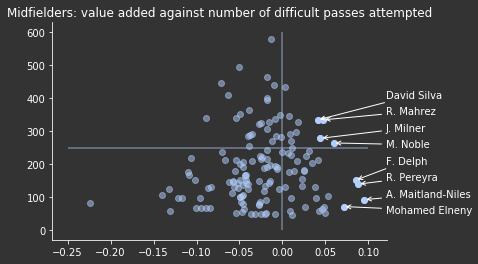

In [569]:
def plot_xpass_per_pass_vs_total_pass_count():
    fig, ax = plt.subplots(nrows=1, ncols=1)

    ax.set_facecolor('#333333')
    fig.set_facecolor('#333333')
    ax.spines["bottom"].set_color("white")
    ax.spines["left"].set_color("white")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    plt.scatter(player_data_with_total_xPass['xPass_per_pass'], player_data_with_total_xPass['pass_attempt_count'],
               color='#b1cefc', alpha=0.5)
    for player, text_position in [
        ['David Silva', (0.12, 400)],
        ['R. Mahrez', (0.12, 350)],
        ['J. Milner', (0.12, 300)],
        ['M. Noble', (0.12, 250)],
        ['F. Delph', (0.12, 200)],
        ['R. Pereyra', (0.12, 150)],
        ['A. Maitland-Niles', (0.12, 100)],
        ['Mohamed Elneny', (0.12, 50)]]:
        this_player_data = player_data_with_total_xPass[player_data_with_total_xPass['shortName'] == player]
        player_xPass_per_game = this_player_data['xPass_per_pass']
        player_pass_count = this_player_data['pass_attempt_count']
        plt.scatter(player_xPass_per_game, player_pass_count, color='#b1cefc')
        plt.annotate(player, (player_xPass_per_game, player_pass_count), 
                     xytext=text_position, color='white',
                     arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='white'))
    plt.vlines(x=0, ymin=0, ymax=600, color='#b1cefc', alpha=0.5)
    plt.hlines(y=250, xmin=-0.25, xmax=0.1, color='#b1cefc', alpha=0.5)
    plt.title('Midfielders: value added against number of difficult passes attempted',
             color='white')
    plt.show()

plot_xpass_per_pass_vs_total_pass_count()

In [688]:
def plot_heatmaps_for_player(player_id, pass_data, player_name):
    pass_data_for_player = pass_data[pass_data['playerId'] == player_id_to_plot]

    x_start_metres = pass_data_for_player['pass_start_x'] * 105 / 100
    y_start_metres = pass_data_for_player['pass_start_y'] * 65 / 100
    # All passes
    plot_event_heatmap(y_start_metres, x_start_metres, f'Number of passes made by {player_name}',
                       no_of_bins=5)
    # Completed passes
    plot_event_heatmap(y_start_metres[pass_data_for_player['success']], 
                       x_start_metres[pass_data_for_player['success']], 
                       'Number of passes successful', no_of_bins=5)
    # Failed passes
    plot_event_heatmap(y_start_metres[~pass_data_for_player['success']], 
                       x_start_metres[~pass_data_for_player['success']], 
                       'Number of passes not successful', no_of_bins=5)
    
    # Difficult passes
    plot_event_heatmap(y_start_metres[pass_data_for_player['xPass'] <= 0.8], 
                       x_start_metres[pass_data_for_player['xPass'] <= 0.8], 
                       'Number of difficult passes', no_of_bins=5)

    plot_event_heatmap(y_start_metres[pass_data_for_player['xPass'] <= 0.8][pass_data_for_player['success']], 
                       x_start_metres[pass_data_for_player['xPass'] <= 0.8][pass_data_for_player['success']], 
                       'Number of difficult successful passes', no_of_bins=5)

    plot_event_heatmap(y_start_metres[pass_data_for_player['xPass'] <= 0.8][~pass_data_for_player['success']], 
                       x_start_metres[pass_data_for_player['xPass'] <= 0.8][~pass_data_for_player['success']], 
                       'Number of difficult failed passes', no_of_bins=5)

In [681]:
def plot_probability_difference_heatmap_for_player(player_id_to_plot, player_name, pass_data,
                                                   player_data, position_of_player):

    pass_data_for_player = pass_data[pass_data['playerId'] == player_id_to_plot]

    x_start_metres = pass_data_for_player['pass_start_x'] * 105 / 100
    y_start_metres = pass_data_for_player['pass_start_y'] * 65 / 100

    histogram_values_all = np.histogram2d(y_start_metres, x_start_metres, bins=5, range=[[0, 65],[0, 105]])
    histogram_values_success = np.histogram2d(y_start_metres[pass_data_for_player['success']], 
                                              x_start_metres[pass_data_for_player['success']], 
                                              bins=5, range=[[0, 65],[0, 105]])
    histogram_values_probability = histogram_values_success[0] / histogram_values_all[0]
    
    pass_data_with_player_data = pass_data.merge(player_data, left_on='playerId', right_on='wyId')
    pass_data_for_position = pass_data_with_player_data[pass_data_with_player_data['player_position'] == position_of_player]
    x_start_metres = pass_data_for_position['pass_start_x'] * 105 / 100
    y_start_metres = pass_data_for_position['pass_start_y'] * 65 / 100

    all_histogram_values_all = np.histogram2d(y_start_metres, x_start_metres, bins=5, range=[[0, 65],[0, 105]])
    all_histogram_values_success = np.histogram2d(y_start_metres[pass_data_for_position['success']], 
                                                  x_start_metres[pass_data_for_position['success']], 
                                                  bins=5, range=[[0, 65],[0, 105]])
    all_histogram_values_probability = all_histogram_values_success[0] / all_histogram_values_all[0]

    difference_in_probability = histogram_values_probability - all_histogram_values_probability
    # Remove values where player has fewer than 10 passes, these are not statistically relevant
    difference_in_probability = [[p if histogram_values_all[0][c][i] > 10 else 0 for i, p in enumerate(row)] for c, row in enumerate(difference_in_probability)]

    fig, ax = FCPython.createPitch(105, 65, 'meters', 'black')
    pos=ax.imshow(difference_in_probability, extent=(0, 105, 0, 65), aspect='auto', vmin=-0.3, vmax=0.3, cmap=plt.cm.PRGn)
    fig.colorbar(pos, ax=ax)
    ax.set_title(f'{player_name} compared to all players')
    plt.tight_layout()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

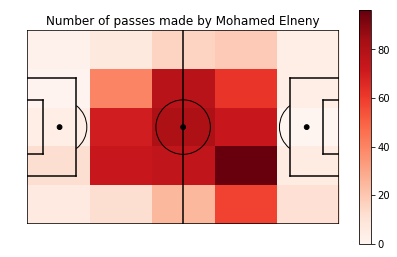

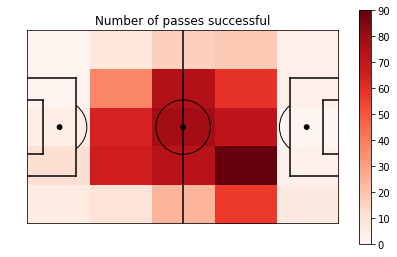

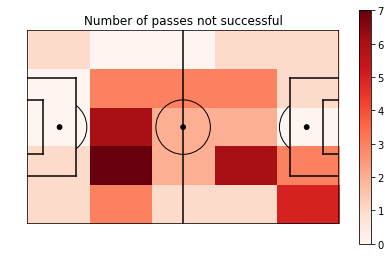

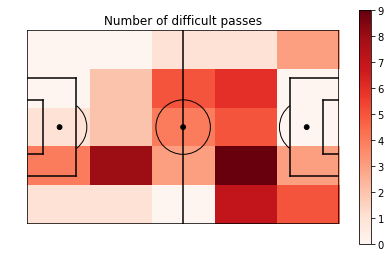

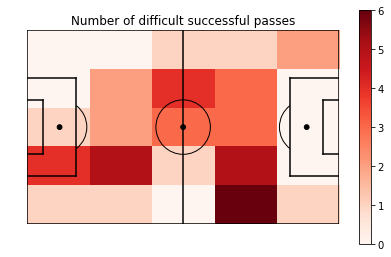

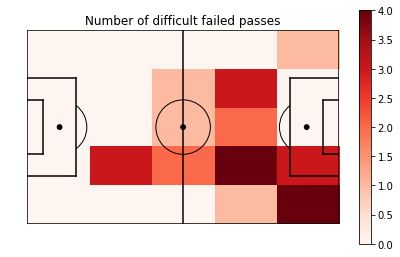

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


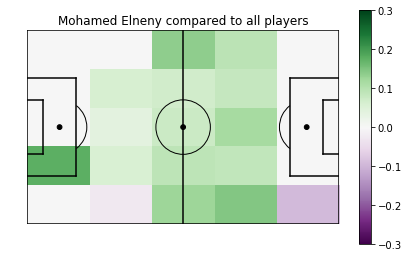

In [689]:
player_name_to_plot = 'Mohamed Elneny'
player_id_to_plot = 120339
plot_heatmaps_for_player(player_id_to_plot, pass_data_for_competition, player_name_to_plot)
plot_probability_difference_heatmap_for_player(player_id_to_plot, player_name_to_plot, pass_data_for_competition,
                                               player_data, 'Midfielder')

New features:
* Style of play:
    * Counter_attacking {1, 0}
    * Passing {1, 0}
* Game state (ie, draw – team winning – team losing)
* Number of red cards

In [358]:
# test_df['team1_goals'] = 0
# test_df['team2_goals'] = 0

# for row in test_df.groupby(['matchId'])['teamId'].unique().reset_index().iterrows():
#     match_rows = test_df['matchId'] == row[1]['matchId']
#     test_df.loc[match_events, 'team1'] = row[1]['teamId'][0]
#     test_df.loc[match_events, 'team2'] = row[1]['teamId'][1]
    
#     match_events = test_df[match_rows]
#     end_match_id = match_events.index.max()
#     tags = match_events['tags'].apply(lambda x: [tag['id'] for tag in x])
#     goals = (tags.apply(lambda x: True if 101 in x else False)) & (match_events['eventName'] == 'Shot')
#     team1_goal = match_events[goals]['teamId'] == match_events[goals]['team1']
#     for index in team1_goal.index:
#         test_df['team1_goals'].iloc[index:end_match_id] += 1
#     team2_goal = match_events[goals]['teamId'] == match_events[goals]['team2']
#     for index in team2_goal.index:
#         test_df['team2_goals'].iloc[index:end_match_id] += 1

# test_df['team1'] = test_df['team1'].astype(int)
# test_df['team2'] = test_df['team2'].astype(int)

In [359]:
# first_match = event_data[event_data['matchId'] == 2499719]
# first_match_shots = first_match[first_match['eventName'] == 'Shot']
# first_match_goals = first_match_shots[first_match_shots['tags'].apply(lambda x: [tag['id'] for tag in x]).apply(lambda x: True if 101 in x else False)]
# first_match_goals